# Testing the Integrated Simulation Platform
This notebook contains codes to test the various functionalities of the integrated simulation platform. You can call any of the modules from the package here. 

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Import required packages

In [2]:
from pathlib import Path

from infrarisk.src.network_recovery import *
import infrarisk.src.simulation as simulation
from infrarisk.src.physical.integrated_network import *
import infrarisk.src.recovery_strategies as strategies

from infrarisk.src.physical.interdependencies import *

from infrarisk.src.optimizer import *
import infrarisk.src.plots as model_plots

#import random

## Create an IntegratedNetwork object

In [3]:
simple_network = IntegratedNetwork(name = "Simple")

### Load the three infrastructure models: Water, Power and Transportation

Three different models are used:
- Water distribution network using **wntr** package
- Power systems using **pandapower** package
- Transportation network using static traffic assignment package developed by Dr. Stephen Boyles (University of Texas at Austin)

In [4]:
MAIN_DIR = Path('../..')
SIM_STEP = 60

network_dir= 'infrarisk/data/networks/in2'
water_folder = MAIN_DIR/f'{network_dir}/water'
power_folder = MAIN_DIR/f'{network_dir}/power'
transp_folder = MAIN_DIR/f'{network_dir}/transportation/'

# load all infrastructure networks
simple_network.load_networks(water_folder=water_folder,
                             power_folder=power_folder,
                             transp_folder=transp_folder,
                             sim_step=SIM_STEP)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



Water network successfully loaded from ../../infrarisk/data/networks/in2/water/water.inp. The analysis type is set to PDA.
initial simulation duration: 60s; hydraulic time step: 60s; pattern time step: 3600s

Power system successfully loaded from ../../infrarisk/data/networks/in2/power/power.json. Single phase power flow simulation will be used.



numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



Transportation network successfully loaded from ../../infrarisk/data/networks/in2/transportation. Static traffic assignment method will be used to calculate travel times.


### Create a Networkx graph of the integrated infrastructure network.

In [5]:
simple_network.generate_integrated_graph()

Successfully added power network to the integrated graph...
Successfully added water network to the integrated graph...
Successfully added transportation network to the integrated graph...
Integrated graph successfully created.
Generating betweenness centrality...


Loading BokehJS ...

### Build interdependencies

Three types of dependencies:
- Power - Water dependencies (eg.: water pump on electric motor, generator on reservoir)
- Power - Transportation dependencies (eg.: road access to power system components for M&R)
- Water - Transportation dependencies (eg.: road access to water network components for M&R)

The dependencies are referenced using two tables in the model.
- **wp_table** for water - power dependencies
- **access_table** for transportation dependencies

In [6]:
dependency_file = MAIN_DIR/f"{network_dir}/dependecies.csv"
simple_network.generate_dependency_table(dependency_file = dependency_file)
simple_network.dependency_table.wp_table

,water_id,power_id,water_type,power_type
0,W_WP9,P_MP1,Pump,Motor
1,W_R9,P_G3,Reservoir,Generator


In [7]:
simple_network.dependency_table.access_table.head()

,origin_id,transp_id,origin_cat,origin_type,access_dist
0,P_B1,T_J2,power,Bus,180.28
1,P_B2,T_J5,power,Bus,111.80
2,P_B3,T_J5,power,Bus,141.42
3,P_B4,T_J8,power,Bus,100.00
4,P_B5,T_J7,power,Bus,100.00


### Set failed components

In [8]:
scenario_folder = "scenarios/test1"
disruption_file = MAIN_DIR/f"{network_dir}/{scenario_folder}/disruption_file.csv"

simple_network.set_disrupted_components(disruption_file=disruption_file)
simple_network.get_disrupted_components()

['W_P21', 'W_WP9', 'T_L2', 'P_L5']

### Set initial crew locations

In [9]:
simple_network.deploy_crews(
    init_power_crew_locs=['T_J8'], 
    init_water_crew_locs=['T_J8'],
    init_transpo_crew_locs= ['T_J8']
    )

Power repair crews successfully deployed.
Water repair crews successfully deployed.
Transportation repair crews successfully deployed.


## Simulation of interdependent effects using a test scenario
### (a) Create NetworkRecovery

In [10]:
network_recovery = NetworkRecovery(simple_network, 
                                   sim_step=SIM_STEP, 
                                   pipe_close_policy="repair",
                                   pipe_closure_delay= 10, 
                                   line_close_policy="sensor_based_line_isolation",
                                   line_closure_delay= 10)

### (b) Create a simulation object

In [11]:
bf_simulation = simulation.NetworkSimulation(network_recovery)

### (c) Generation of random repair order

In [12]:
capacity_strategy = strategies.HandlingCapacityStrategy(simple_network)
capacity_strategy.set_repair_order()
repair_order = capacity_strategy.get_repair_order()

import os
if not os.path.exists(MAIN_DIR/f"{network_dir}/{scenario_folder}/capacity"):
    os.makedirs(MAIN_DIR/f"{network_dir}/{scenario_folder}/capacity")

In [13]:
#Generate a random repair order
# repair_order = network_recovery.network.get_disrupted_components()
# random.shuffle(repair_order)
print('Current repair order is {}'.format(repair_order))

Current repair order is ['T_L2', 'P_L5', 'W_WP9', 'W_P21']


### (d) Generation of event tables

In [14]:
bf_simulation.network_recovery.schedule_recovery(repair_order)

Components yet to repair 1
Repair T_L2: The transpo crew 1 is at T_J8 at t = 2.0 minutes. It takes 19 minutes to reach nearest node T_J3, the nearest transportation node from T_L2.


Components yet to repair 3
Repair P_L5: The power crew 1 is at T_J8 at t = 2.0 minutes. It takes 14 minutes to reach nearest node T_J5, the nearest transportation node from P_L5.


Components yet to repair 2
Repair W_WP9: The water crew 1 is at T_J8 at t = 2.0 minutes. It takes 23 minutes to reach nearest node T_J2, the nearest transportation node from W_WP9.


Components yet to repair 1
Repair W_P21: The water crew 1 is at T_J2 at t = 97.0 minutes. It takes 19 minutes to reach nearest node T_J5, the nearest transportation node from W_P21.


All restoration actions are successfully scheduled.
Total travel times: power: 14 mins, water: 42 min, transportation: 19 mins
Total recovery times: power: 300.0 mins, water: 432.0 min, transportation: 360.0 mins
Scheduling recovery actions completed in 0.0316711989999

In [15]:
#bf_simulation.network_recovery.event_table.to_csv("event_tbl.csv", sep = "\t", index = False)
bf_simulation.expand_event_table()

### (e) Simulation of interdependent effects

In [16]:
resilience_metrics = bf_simulation.simulate_interdependent_effects(
    bf_simulation.network_recovery)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



Time instances for which simulations will be performed:
 [60, 180, 1020, 1260, 1500, 5700, 5820, 5940, 7020, 18900, 19020, 19140, 22740, 22860, 22980, 28500, 28620]
Simulating network conditions at 60/28620 s...
Simulation time:  60.0 ; Hydraulic time step:  60 ; Report time step:  60
Updating status of directly affected components between 60.0 and 180.0...


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



******************

Simulating network conditions at 180/28620 s...
Simulation time:  180.0 ; Hydraulic time step:  60 ; Report time step:  60
Updating status of directly affected components between 180.0 and 1020.0...


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



The weighted AUC value based on ECS is 0.002
The weighted AUC value based on PCS is 0.0005
******************

Simulating network conditions at 1020/28620 s...
Simulation time:  1020.0 ; Hydraulic time step:  60 ; Report time step:  60
Updating status of directly affected components between 1020.0 and 1260.0...


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



The weighted AUC value based on ECS is 0.031
The weighted AUC value based on PCS is 0.0045
******************

Simulating network conditions at 1260/28620 s...
Simulation time:  1260.0 ; Hydraulic time step:  60 ; Report time step:  60
Updating status of directly affected components between 1260.0 and 1500.0...


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



The weighted AUC value based on ECS is 0.0395
The weighted AUC value based on PCS is 0.006
******************

Simulating network conditions at 1500/28620 s...
Simulation time:  1500.0 ; Hydraulic time step:  60 ; Report time step:  60
Updating status of directly affected components between 1500.0 and 5700.0...


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



The weighted AUC value based on ECS is 0.048
The weighted AUC value based on PCS is 0.007
******************

Simulating network conditions at 5700/28620 s...
Simulation time:  5700.0 ; Hydraulic time step:  60 ; Report time step:  60
Updating status of directly affected components between 5700.0 and 5820.0...


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



The weighted AUC value based on ECS is 0.2
The weighted AUC value based on PCS is 0.0345
******************

Simulating network conditions at 5820/28620 s...
Simulation time:  5820.0 ; Hydraulic time step:  60 ; Report time step:  60
Updating status of directly affected components between 5820.0 and 5940.0...


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



The weighted AUC value based on ECS is 0.20900000000000002
The weighted AUC value based on PCS is 0.0395
******************

Simulating network conditions at 5940/28620 s...
Simulation time:  5940.0 ; Hydraulic time step:  60 ; Report time step:  60
Updating status of directly affected components between 5940.0 and 7020.0...


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



The weighted AUC value based on ECS is 0.21750000000000003
The weighted AUC value based on PCS is 0.045
******************

Simulating network conditions at 7020/28620 s...
Simulation time:  7020.0 ; Hydraulic time step:  60 ; Report time step:  60
Updating status of directly affected components between 7020.0 and 18900.0...


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



The weighted AUC value based on ECS is 0.2945
The weighted AUC value based on PCS is 0.0885
******************

Simulating network conditions at 18900/28620 s...
Simulation time:  18900.0 ; Hydraulic time step:  60 ; Report time step:  60
Updating status of directly affected components between 18900.0 and 19020.0...
The weighted AUC value based on ECS is 0.7070000000000001
The weighted AUC value based on PCS is 0.1495
******************

Simulating network conditions at 19020/28620 s...
Simulation time:  19020.0 ; Hydraulic time step:  60 ; Report time step:  60
Updating status of directly affected components between 19020.0 and 19140.0...


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



The weighted AUC value based on ECS is 0.7090000000000001
The weighted AUC value based on PCS is 0.1495
******************

Simulating network conditions at 19140/28620 s...
Simulation time:  19140.0 ; Hydraulic time step:  60 ; Report time step:  60
Updating status of directly affected components between 19140.0 and 22740.0...
The weighted AUC value based on ECS is 0.7090000000000001
The weighted AUC value based on PCS is 0.1495
******************

Simulating network conditions at 22740/28620 s...
Simulation time:  22740.0 ; Hydraulic time step:  60 ; Report time step:  60
Updating status of directly affected components between 22740.0 and 22860.0...
The weighted AUC value based on ECS is 0.7090000000000001
The weighted AUC value based on PCS is 0.1495
Simulation completed in 1 s


In [17]:
strategy = 'capacity'
bf_simulation.write_results(f"{MAIN_DIR}/{network_dir}/{scenario_folder}/{strategy}", 
                            resilience_metrics)

The simulation results successfully saved to ../../infrarisk/data/networks/in2/scenarios/test1/capacity


### (f) Calculation of resilience metric

In [18]:
resilience_metrics.calculate_power_resmetric(network_recovery)

In [19]:
resilience_metrics.calculate_water_resmetrics(network_recovery)

In [20]:
resilience_metrics.set_weighted_auc_metrics()

The weighted AUC value based on ECS is 0.7090000000000001
The weighted AUC value based on PCS is 0.1495


# Plot network performance during the disruption

### Overall system performance considering indirect effects

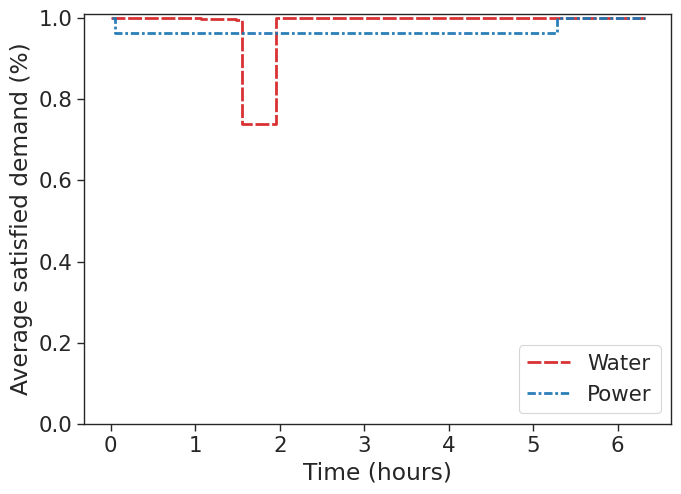

In [21]:
model_plots.plot_interdependent_effects(resilience_metrics, metric = 'pcs', title = False)

In [22]:
model_plots.plot_disruptions_and_crews(simple_network)

{'power': ['P_L5'], 'water': ['W_P21', 'W_WP9'], 'transpo': []}


Loading BokehJS ...